# Question 7

In [1]:
from urllib.parse import urlparse
from shapely.geometry import Point
from geopandas.tools import sjoin
from sklearn.neighbors import KernelDensity
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
from libpysal.weights import Queen
from esda.moran import Moran
from esda.moran import Moran_Local
import requests
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pysal
from pysal.explore import esda

/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

##  - Data Cleaning -

In [2]:
# 导入点数据
file_path = 'cleaned_data_2023.csv'
df = pd.read_csv(file_path)


#filter out ghost room data (room_type=Private room)
filtered_data = df[df['room_type'] == 'Private room']
# get 13375 ghost room data of 37242 data
#Then tranform coordinate into point and make it GeoDataframe
df_with_coordinates = pd.DataFrame(filtered_data)
geometry = [Point(lon, lat) for lon, lat in zip(df_with_coordinates['longitude'], df_with_coordinates['latitude'])]
gdf_with_coordinates = gpd.GeoDataFrame(df_with_coordinates, geometry=geometry, crs="EPSG:4326")
print(gdf_with_coordinates)

                       id last_scraped    host_id host_name host_is_superhost  \
0                   92644   2023-09-06     498201   Dee Dee                 f   
2                   13913   2023-09-06      54730     Alina                 f   
4                   93734   2023-09-07     497514   William                 t   
7                   96052   2023-09-06     448154     Aneta                 f   
9                   97506   2023-09-07     497537     Maria                 f   
...                   ...          ...        ...       ...               ...   
37230  968783496505858173   2023-09-06  534493799    Amanda                 f   
37231  968803060946575409   2023-09-06  534516902     Irena                 f   
37236  970100852579649966   2023-09-06   24366284   Claudia                 f   
37240  971887875299343051   2023-09-06  320860309    Khalid                 f   
37241  972316487904830732   2023-09-06  433303389      Bora                 f   

       host_listings_count 

In [3]:
# 导入伦敦地图
def cache_data(source_url, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
        
    filename = source_url.split('/')[-1].split('?')[0]  # 假设URL以文件名结尾
    file_path = os.path.join(dest_dir, filename)
    
    if not os.path.isfile(file_path):
        response = requests.get(source_url)
        if response.status_code == 200:
            with open(file_path, 'wb') as file:
                file.write(response.content)
        else:
            raise Exception(f"Failed to download {source_url}")

    return file_path
london_map = gpd.read_file(
    cache_data('https://github.com/ZhengyongLiu/FSDS_GroupAssignment_Data/blob/main/Borough/London_Borough_Excluding_MHW.zip?raw=true', 
               os.path.join('data','geo')), driver='ESRI Shapefile')
london_vector_map = london_map.to_crs(epsg=4326)

print(london_vector_map)

                      NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  \
0     Kingston upon Thames  E09000021   3726.117       0.000         F   
1                  Croydon  E09000008   8649.441       0.000         F   
2                  Bromley  E09000006  15013.487       0.000         F   
3                 Hounslow  E09000018   5658.541      60.755         F   
4                   Ealing  E09000009   5554.428       0.000         F   
5                 Havering  E09000016  11445.735     210.763         F   
6               Hillingdon  E09000017  11570.063       0.000         F   
7                   Harrow  E09000015   5046.330       0.000         F   
8                    Brent  E09000005   4323.270       0.000         F   
9                   Barnet  E09000003   8674.837       0.000         F   
10                 Lambeth  E09000022   2724.940      43.927         T   
11               Southwark  E09000028   2991.340     105.139         T   
12                Lewisham  E09000023 

In [4]:
# 计算各地区面积
london_vector_map = london_vector_map.to_crs(epsg=27700)

# 计算面积
london_vector_map['area'] = london_vector_map['geometry'].area/ 10**6


In [5]:
#检查数据类型
numeric_columns = london_vector_map.select_dtypes(include='number').columns
print(numeric_columns)

Index(['HECTARES', 'NONLD_AREA', 'SUB_2009', 'SUB_2006', 'area'], dtype='object')


In [6]:
#更改类型
london_vector_map['area'] =london_vector_map['area'].astype(float)

In [7]:
#再次检查数据类型
numeric_columns = london_vector_map.select_dtypes(include='number').columns
print(numeric_columns)

Index(['HECTARES', 'NONLD_AREA', 'SUB_2009', 'SUB_2006', 'area'], dtype='object')


In [8]:
london_vector_map = london_vector_map.to_crs(epsg=4326)

In [9]:
# spatial connection 
merged_gdf = gpd.sjoin(gdf_with_coordinates, london_vector_map, how='left', op='within')

print(merged_gdf)

                       id last_scraped    host_id host_name host_is_superhost  \
0                   92644   2023-09-06     498201   Dee Dee                 f   
2                   13913   2023-09-06      54730     Alina                 f   
4                   93734   2023-09-07     497514   William                 t   
7                   96052   2023-09-06     448154     Aneta                 f   
9                   97506   2023-09-07     497537     Maria                 f   
...                   ...          ...        ...       ...               ...   
37230  968783496505858173   2023-09-06  534493799    Amanda                 f   
37231  968803060946575409   2023-09-06  534516902     Irena                 f   
37236  970100852579649966   2023-09-06   24366284   Claudia                 f   
37240  971887875299343051   2023-09-06  320860309    Khalid                 f   
37241  972316487904830732   2023-09-06  433303389      Bora                 f   

       host_listings_count 

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [10]:
selected_columns = ['NAME','latitude', 'longitude', 'geometry', 'area','GSS_CODE']

merged_gdf = merged_gdf[selected_columns]

print(merged_gdf)

                         NAME   latitude  longitude  \
0                  Wandsworth  51.442010  -0.187390   
2                   Islington  51.568610  -0.112700   
4                   Greenwich  51.476180   0.014420   
7                       Brent  51.559300  -0.224970   
9                     Lambeth  51.429960  -0.121610   
...                       ...        ...        ...   
37230                 Lambeth  51.468540  -0.135030   
37231  Hammersmith and Fulham  51.501899  -0.238283   
37236               Islington  51.524524  -0.099921   
37240           Tower Hamlets  51.509228  -0.070246   
37241              Wandsworth  51.444890  -0.193566   

                        geometry       area   GSS_CODE  
0      POINT (-0.18739 51.44201)  34.264163  E09000032  
2      POINT (-0.11270 51.56861)  14.856653  E09000019  
4       POINT (0.01442 51.47618)  47.334073  E09000011  
7      POINT (-0.22497 51.55930)  43.232640  E09000005  
9      POINT (-0.12161 51.42996)  26.810042  E09000022

In [11]:
merged_gdf = merged_gdf.rename(columns={'NAME': 'name'})

In [12]:
print(merged_gdf)

                         name   latitude  longitude  \
0                  Wandsworth  51.442010  -0.187390   
2                   Islington  51.568610  -0.112700   
4                   Greenwich  51.476180   0.014420   
7                       Brent  51.559300  -0.224970   
9                     Lambeth  51.429960  -0.121610   
...                       ...        ...        ...   
37230                 Lambeth  51.468540  -0.135030   
37231  Hammersmith and Fulham  51.501899  -0.238283   
37236               Islington  51.524524  -0.099921   
37240           Tower Hamlets  51.509228  -0.070246   
37241              Wandsworth  51.444890  -0.193566   

                        geometry       area   GSS_CODE  
0      POINT (-0.18739 51.44201)  34.264163  E09000032  
2      POINT (-0.11270 51.56861)  14.856653  E09000019  
4       POINT (0.01442 51.47618)  47.334073  E09000011  
7      POINT (-0.22497 51.55930)  43.232640  E09000005  
9      POINT (-0.12161 51.42996)  26.810042  E09000022

In [13]:
# 根据 "name" 列进行分组，并计算每个分组的数据个数
grouped_counts = merged_gdf['name'].value_counts().reset_index()
grouped_counts.columns = ['name', 'groupcounts']

# 将计数列添加到原始 GeoDataFrame 中
merged_gdf = merged_gdf.merge(grouped_counts, on='name', how='left')

# 打印结果
print(merged_gdf)

                         name   latitude  longitude  \
0                  Wandsworth  51.442010  -0.187390   
1                   Islington  51.568610  -0.112700   
2                   Greenwich  51.476180   0.014420   
3                       Brent  51.559300  -0.224970   
4                     Lambeth  51.429960  -0.121610   
...                       ...        ...        ...   
13370                 Lambeth  51.468540  -0.135030   
13371  Hammersmith and Fulham  51.501899  -0.238283   
13372               Islington  51.524524  -0.099921   
13373           Tower Hamlets  51.509228  -0.070246   
13374              Wandsworth  51.444890  -0.193566   

                        geometry       area   GSS_CODE  groupcounts  
0      POINT (-0.18739 51.44201)  34.264163  E09000032        659.0  
1      POINT (-0.11270 51.56861)  14.856653  E09000019        555.0  
2       POINT (0.01442 51.47618)  47.334073  E09000011        400.0  
3      POINT (-0.22497 51.55930)  43.232640  E09000005     

In [14]:
wandsworth_data = merged_gdf[merged_gdf['name'] == 'Wandsworth']

print(wandsworth_data)

             name   latitude  longitude                   geometry       area  \
0      Wandsworth  51.442010  -0.187390  POINT (-0.18739 51.44201)  34.264163   
43     Wandsworth  51.428650  -0.157250  POINT (-0.15725 51.42865)  34.264163   
53     Wandsworth  51.470220  -0.170080  POINT (-0.17008 51.47022)  34.264163   
66     Wandsworth  51.470430  -0.171550  POINT (-0.17155 51.47043)  34.264163   
68     Wandsworth  51.475650  -0.151590  POINT (-0.15159 51.47565)  34.264163   
...           ...        ...        ...                        ...        ...   
13306  Wandsworth  51.452388  -0.230382  POINT (-0.23038 51.45239)  34.264163   
13316  Wandsworth  51.459868  -0.183924  POINT (-0.18392 51.45987)  34.264163   
13336  Wandsworth  51.441920  -0.221410  POINT (-0.22141 51.44192)  34.264163   
13342  Wandsworth  51.440850  -0.186720  POINT (-0.18672 51.44085)  34.264163   
13374  Wandsworth  51.444890  -0.193566  POINT (-0.19357 51.44489)  34.264163   

        GSS_CODE  groupcoun

In [15]:
#计算密度
merged_gdf['density'] = merged_gdf['groupcounts'] / merged_gdf['area']

# 打印结果
print(merged_gdf[['name', 'density']])

                         name    density
0                  Wandsworth  19.232923
1                   Islington  37.357002
2                   Greenwich   8.450572
3                       Brent  12.212995
4                     Lambeth  29.839566
...                       ...        ...
13370                 Lambeth  29.839566
13371  Hammersmith and Fulham  27.930887
13372               Islington  37.357002
13373           Tower Hamlets  53.342267
13374              Wandsworth  19.232923

[13375 rows x 2 columns]


In [16]:

print(merged_gdf)

                         name   latitude  longitude  \
0                  Wandsworth  51.442010  -0.187390   
1                   Islington  51.568610  -0.112700   
2                   Greenwich  51.476180   0.014420   
3                       Brent  51.559300  -0.224970   
4                     Lambeth  51.429960  -0.121610   
...                       ...        ...        ...   
13370                 Lambeth  51.468540  -0.135030   
13371  Hammersmith and Fulham  51.501899  -0.238283   
13372               Islington  51.524524  -0.099921   
13373           Tower Hamlets  51.509228  -0.070246   
13374              Wandsworth  51.444890  -0.193566   

                        geometry       area   GSS_CODE  groupcounts    density  
0      POINT (-0.18739 51.44201)  34.264163  E09000032        659.0  19.232923  
1      POINT (-0.11270 51.56861)  14.856653  E09000019        555.0  37.357002  
2       POINT (0.01442 51.47618)  47.334073  E09000011        400.0   8.450572  
3      POINT (-

In [17]:
selected_columns_2 = ['name','latitude','longitude','density','GSS_CODE']

merged_gdf = merged_gdf[selected_columns_2]

print(merged_gdf)

                         name   latitude  longitude    density   GSS_CODE
0                  Wandsworth  51.442010  -0.187390  19.232923  E09000032
1                   Islington  51.568610  -0.112700  37.357002  E09000019
2                   Greenwich  51.476180   0.014420   8.450572  E09000011
3                       Brent  51.559300  -0.224970  12.212995  E09000005
4                     Lambeth  51.429960  -0.121610  29.839566  E09000022
...                       ...        ...        ...        ...        ...
13370                 Lambeth  51.468540  -0.135030  29.839566  E09000022
13371  Hammersmith and Fulham  51.501899  -0.238283  27.930887  E09000013
13372               Islington  51.524524  -0.099921  37.357002  E09000019
13373           Tower Hamlets  51.509228  -0.070246  53.342267  E09000030
13374              Wandsworth  51.444890  -0.193566  19.232923  E09000032

[13375 rows x 5 columns]


In [18]:
merged_gdf = merged_gdf.groupby('GSS_CODE').agg(
    density=('density', 'first'),
    name=('name', 'first'),
    latitude=('latitude', 'first'),
    longitude=('longitude', 'first')
).reset_index()

print(merged_gdf)

     GSS_CODE    density                    name   latitude  longitude
0   E09000001   7.575952          City of London  51.510435  -0.095105
1   E09000002   3.849583    Barking and Dagenham  51.540720   0.152460
2   E09000003   4.334378                  Barnet  51.585900  -0.164340
3   E09000004   2.410027                  Bexley  51.492500   0.131470
4   E09000005  12.212995                   Brent  51.559300  -0.224970
5   E09000006   1.305493                 Bromley  51.422140   0.019060
6   E09000007  38.367463                  Camden  51.552370  -0.199540
7   E09000008   4.416469                 Croydon  51.384300  -0.127230
8   E09000009   7.921598                  Ealing  51.504260  -0.334440
9   E09000010   2.907536                 Enfield  51.611370  -0.118880
10  E09000011   8.450572               Greenwich  51.476180   0.014420
11  E09000012  36.484802                 Hackney  51.576656  -0.061099
12  E09000013  27.930887  Hammersmith and Fulham  51.486532  -0.225619
13  E0

In [19]:
geometry = [Point(xy) for xy in zip(merged_gdf['longitude'], merged_gdf['latitude'])]
crs = "EPSG:4326"
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry=geometry, crs=crs)

In [20]:
points_joined_gdf = gpd.sjoin(london_vector_map,merged_gdf, how='left', op='intersects')

print(points_joined_gdf)

                      NAME GSS_CODE_left   HECTARES  NONLD_AREA ONS_INNER  \
0     Kingston upon Thames     E09000021   3726.117       0.000         F   
1                  Croydon     E09000008   8649.441       0.000         F   
2                  Bromley     E09000006  15013.487       0.000         F   
3                 Hounslow     E09000018   5658.541      60.755         F   
4                   Ealing     E09000009   5554.428       0.000         F   
5                 Havering     E09000016  11445.735     210.763         F   
6               Hillingdon     E09000017  11570.063       0.000         F   
7                   Harrow     E09000015   5046.330       0.000         F   
8                    Brent     E09000005   4323.270       0.000         F   
9                   Barnet     E09000003   8674.837       0.000         F   
10                 Lambeth     E09000022   2724.940      43.927         T   
11               Southwark     E09000028   2991.340     105.139         T   

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


##  - Density Distribution Map -

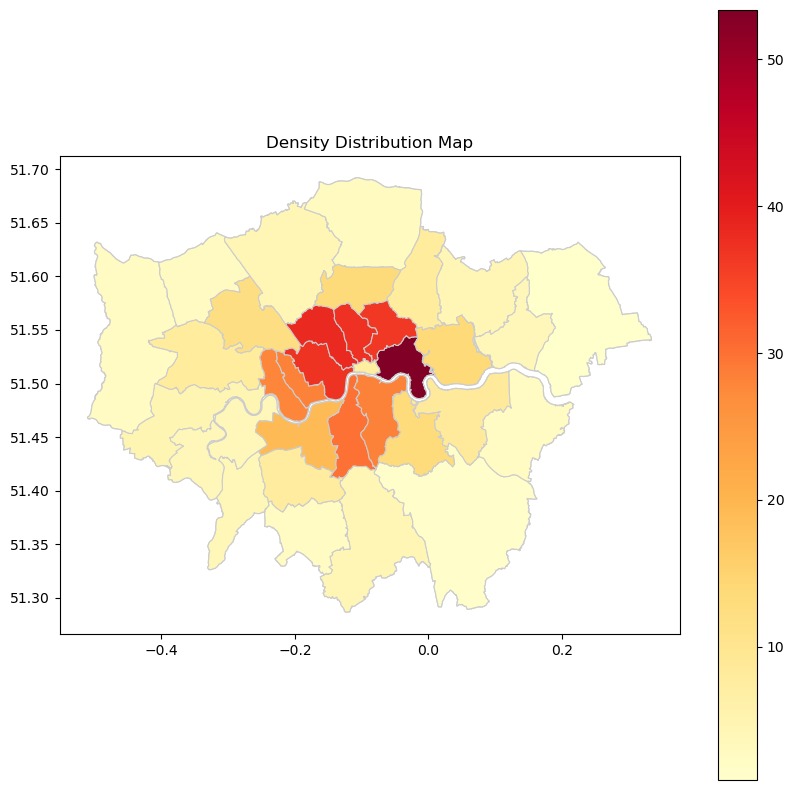

In [21]:
# 设置图形的大小
fig, ax = plt.subplots(figsize=(10, 10))

#添加底图
london_vector_map.plot(ax=plt.gca(), color='none', edgecolor='grey',alpha=0.4)

# 绘制密度分布图
points_joined_gdf.plot(column='density', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# 添加标题
plt.title('Density Distribution Map')

# 显示图形
plt.show()

##  - Local Moran’s I -

In [22]:
import geopandas as gpd
from libpysal import weights
from esda.moran import Moran

In [23]:
# 创建空间权重矩阵
w = weights.Queen.from_dataframe(points_joined_gdf)

# 标准化权重矩阵
w.transform = 'R'

# 提取人口密度列
y = points_joined_gdf['density']

# 进行莫兰指数分析
moran = Moran(y, w)

# 输出莫兰指数结果
print("Moran's I:", moran.I)
print("Expected Moran's I:", moran.EI)
print("Moran's I p-value:", moran.p_sim)

Moran's I: 0.284110990009918
Expected Moran's I: -0.03125
Moran's I p-value: 0.009


/tmp/ipykernel_31579/1979069511.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry_center'] = gdf.geometry.centroid


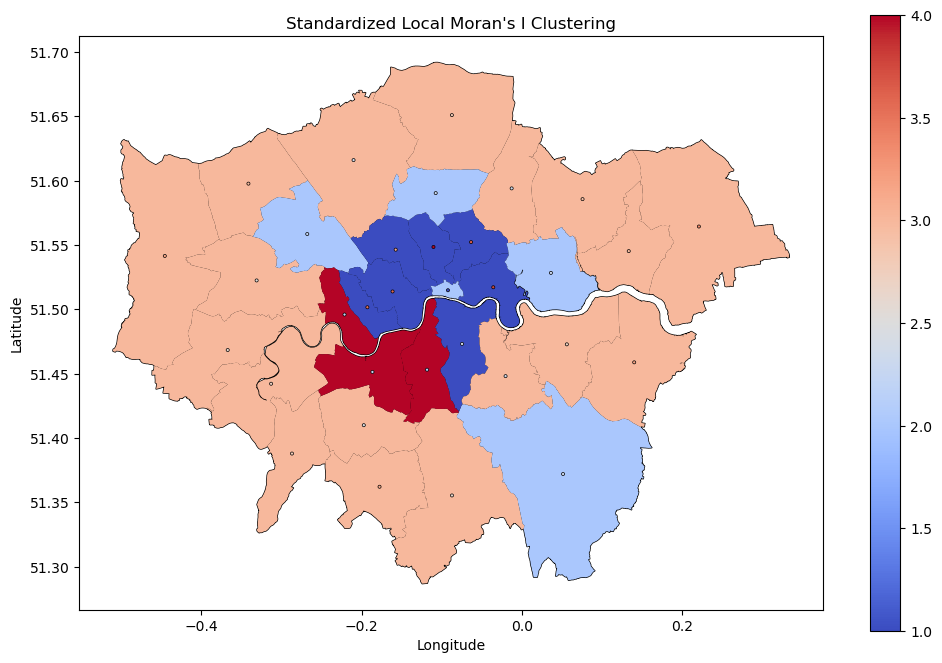

In [24]:
import geopandas as gpd
from libpysal import weights
from esda.moran import Moran_Local
import matplotlib.pyplot as plt

def visualize_local_moran(gdf, variable_column, base_map, cmap='coolwarm'):
    # 创建空间权重矩阵
    w = weights.Queen.from_dataframe(gdf)

    # 标准化权重矩阵
    w.transform = 'R'

    # 提取变量列
    y = gdf[variable_column]

    # 进行局部莫兰指数分析
    moran_loc = Moran_Local(y, w)

    # 在 GeoDataFrame 中添加局部莫兰指数聚类结果列
    gdf['lisa_cluster'] = moran_loc.q

    # 标准化局部莫兰指数（z-score）
    lisa_std = (moran_loc.Is - moran_loc.EI_sim.mean()) / moran_loc.EI_sim.std()

    # 创建地图
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # 添加底图
    base_map.plot(ax=ax, color='lightgray', edgecolor='black')

    # 绘制标准化局部莫兰指数结果
    gdf.plot(column='lisa_cluster', cmap=cmap, legend=True, ax=ax)
    
    # 绘制散点图（多边形的中心点）
    gdf['geometry_center'] = gdf.geometry.centroid
    plt.scatter(gdf.geometry_center.x, gdf.geometry_center.y, c=lisa_std, cmap=cmap, marker='.', s=20, edgecolors='k', linewidths=0.5)

    # 添加标题和标签
    plt.title('Standardized Local Moran\'s I Clustering')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # 显示地图
    plt.show()

# 使用函数，传入你的 GeoDataFrame、变量列名和底图数据
visualize_local_moran(points_joined_gdf, 'density', london_vector_map)

##  - Getis Ord General G -

/opt/conda/lib/python3.11/site-packages/esda/crand.py:328: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  rstats = stat_func(chunk_start + i, z, permuted_ids, weights_i, scaling)
/opt/conda/lib/python3.11/site-packages/esda/crand.py:328: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  rstats = stat_func(chunk_start + i, z, permuted_ids, weights_i, scaling)
/opt/con

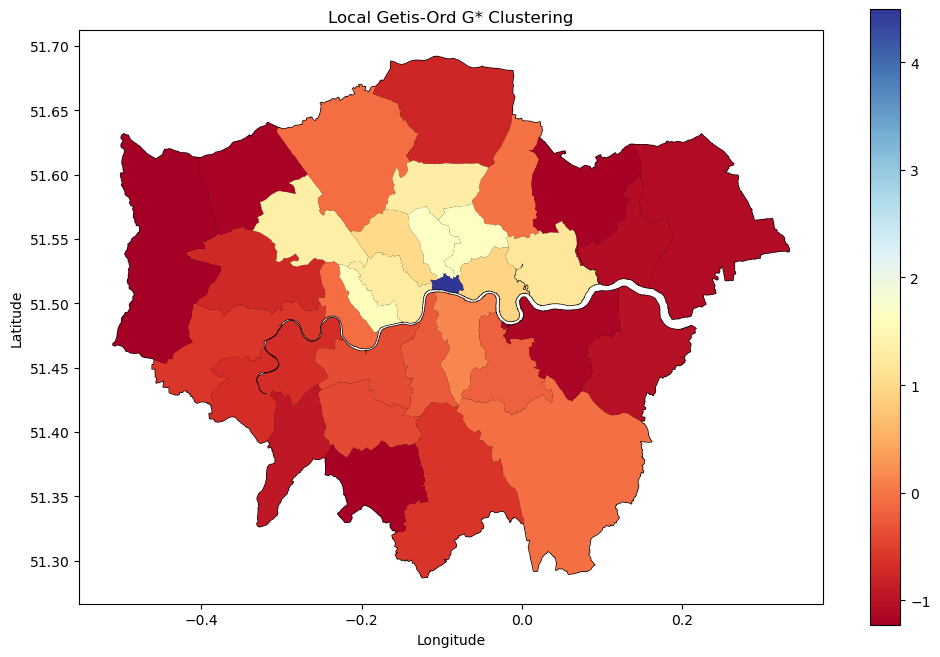

In [25]:
import geopandas as gpd
from libpysal import weights
from esda.getisord import G_Local
import matplotlib.pyplot as plt

def visualize_local_getisord(gdf, variable_column, base_map, cmap='coolwarm'):
    # 创建空间权重矩阵
    w = weights.Queen.from_dataframe(gdf)

    # 标准化权重矩阵
    w.transform = 'R'

    # 提取变量列
    y = gdf[variable_column]

    # 进行 Local Getis-Ord G* 分析
    getisord = G_Local(y, w)

    # 在 GeoDataFrame 中添加局部 Getis-Ord G* 聚类结果列
    gdf['getisord_cluster'] = getisord.z_sim

    # 创建地图
    fig, ax = plt.subplots(figsize=(12, 8))

    # 添加底图
    base_map.plot(ax=ax, color='lightgray', edgecolor='black')

    # 绘制局部 Getis-Ord G* 聚类结果
    gdf.plot(column='getisord_cluster', cmap=cmap, legend=True, ax=ax)

    # 添加标题和标签
    plt.title('Local Getis-Ord G* Clustering')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # 显示地图
    plt.show()

# 使用函数，传入你的 GeoDataFrame、变量列名和底图数据
visualize_local_getisord(points_joined_gdf, 'density', london_vector_map, cmap='RdYlBu')

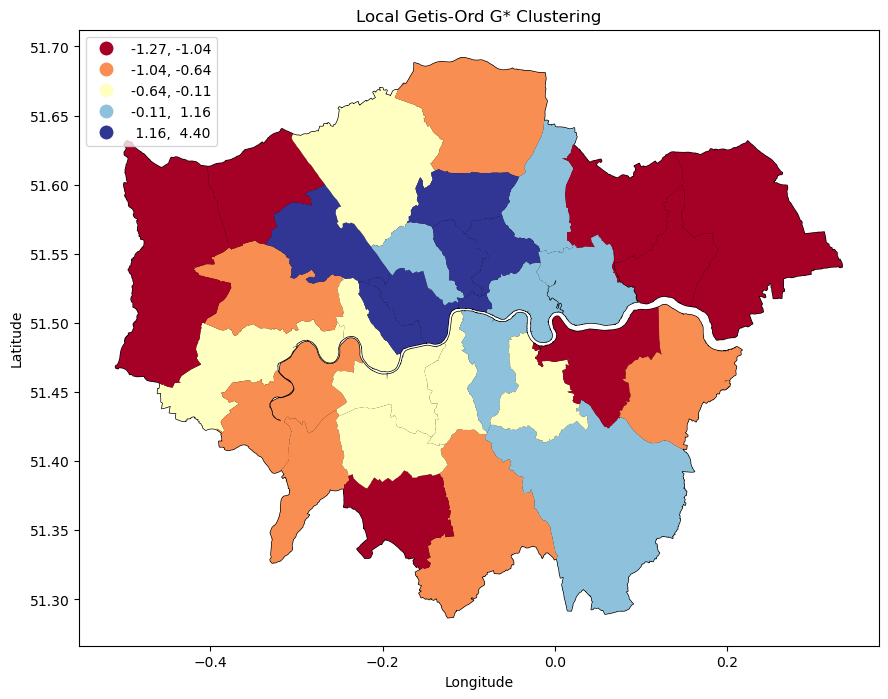

In [26]:
import geopandas as gpd
from libpysal import weights
from esda.getisord import G_Local
import matplotlib.pyplot as plt

def visualize_local_getisord(gdf, variable_column, base_map, cmap='coolwarm'):
    # 创建空间权重矩阵
    w = weights.Queen.from_dataframe(gdf)

    # 标准化权重矩阵
    w.transform = 'R'

    # 提取变量列
    y = gdf[variable_column]

    # 进行 Local Getis-Ord G* 分析
    getisord = G_Local(y, w)

    # 在 GeoDataFrame 中添加局部 Getis-Ord G* 聚类结果列
    gdf['getisord_cluster'] = getisord.z_sim

    # 创建地图
    fig, ax = plt.subplots(figsize=(12, 8))

    # 添加底图
    base_map.plot(ax=ax, color='lightgray', edgecolor='black')

    # 绘制局部 Getis-Ord G* 聚类结果，并反转颜色
    gdf.plot(column='getisord_cluster', cmap=cmap, legend=True, ax=ax, scheme='quantiles', legend_kwds={'loc': 'upper left'})

    # 添加标题和标签
    plt.title('Local Getis-Ord G* Clustering')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # 显示地图
    plt.show()

# 使用函数，传入你的 GeoDataFrame、变量列名和底图数据
visualize_local_getisord(points_joined_gdf, 'density', london_vector_map, cmap='RdYlBu')

##  - 不好看的废图 -

/tmp/ipykernel_31579/2689520269.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry_center'] = gdf.geometry.centroid


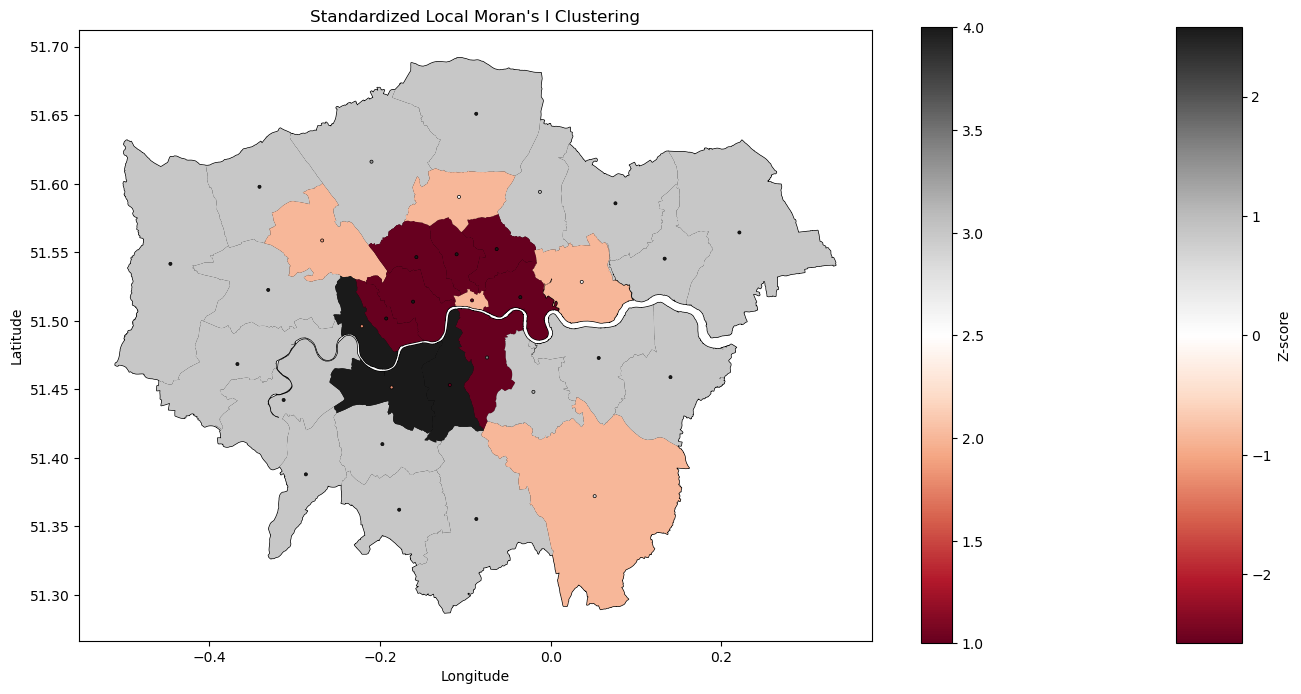

In [27]:
import geopandas as gpd
from libpysal import weights
from esda.moran import Moran_Local
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualize_local_moran(gdf, variable_column, base_map, cmap='coolwarm', breaks=None):
    # 创建空间权重矩阵
    w = weights.Queen.from_dataframe(gdf)

    # 标准化权重矩阵
    w.transform = 'R'

    # 提取变量列
    y = gdf[variable_column]

    # 进行局部莫兰指数分析
    moran_loc = Moran_Local(y, w)

    # 在 GeoDataFrame 中添加局部莫兰指数聚类结果列
    gdf['lisa_cluster'] = moran_loc.q

    # 标准化局部莫兰指数（z-score）
    lisa_std = (moran_loc.Is - moran_loc.EI_sim.mean()) / moran_loc.EI_sim.std()

    # 创建地图和图例的网格规范
    fig, (ax, cax) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [15, 1]})

    # 添加底图
    base_map.plot(ax=ax, color='lightgray', edgecolor='black')

    # 绘制标准化局部莫兰指数结果
    gdf.plot(column='lisa_cluster', cmap=cmap, legend=True, ax=ax)
    
    # 绘制散点图（多边形的中心点）
    gdf['geometry_center'] = gdf.geometry.centroid
    
    # 使用指定的分隔点绘制散点图
    norm = Normalize(vmin=breaks[0], vmax=breaks[-1])
    scatter = ax.scatter(gdf.geometry_center.x, gdf.geometry_center.y, c=lisa_std, cmap=cmap, marker='.', s=20, edgecolors='k', linewidths=0.5, norm=norm)

    # 添加颜色条
    cbar = plt.colorbar(scatter, cax=cax)
    cbar.set_label("Z-score")

    # 添加标题和标签
    ax.set_title('Standardized Local Moran\'s I Clustering')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # 显示地图
    plt.show()

# 使用函数，传入你的 GeoDataFrame、变量列名和底图数据
# 注意：确保 breaks2 已经被定义
breaks = [-2.58, -1.96, -1.65, 1.65, 1.96, 2.58]
visualize_local_moran(points_joined_gdf, 'density', london_vector_map, cmap='RdGy', breaks=breaks)